In [1]:
# import
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import zipfile
import os
import folium

In [2]:
# load dataset
earthquakes = pd.read_csv('earthquake_merged.csv')
eq = earthquakes.dropna(subset=['Latitude', 'Longitude'])

FileNotFoundError: [Errno 2] No such file or directory: 'earthquake_merged.csv'

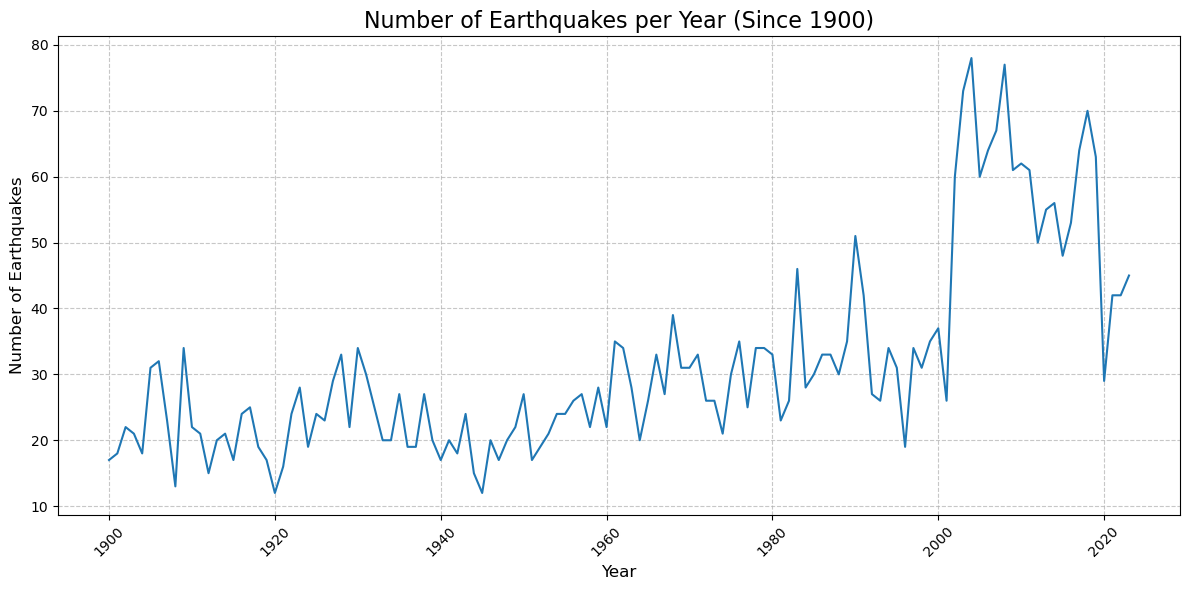

In [ ]:
# Group earthquakes by year and count
earthquakes_per_year = eq[(eq['Year'] >= 1900) & (eq['Year'] < 2024)].groupby('Year').size().reset_index(name='Number of Earthquakes')

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(earthquakes_per_year['Year'], earthquakes_per_year['Number of Earthquakes'])

# Customize the plot
plt.title('Number of Earthquakes per Year (Since 1900)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
alt.Chart(eq).mark_bar().encode(
    alt.X('Mag:Q', bin = alt.BinParams(maxbins = 10)),
    alt.Y('count()')
)

C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

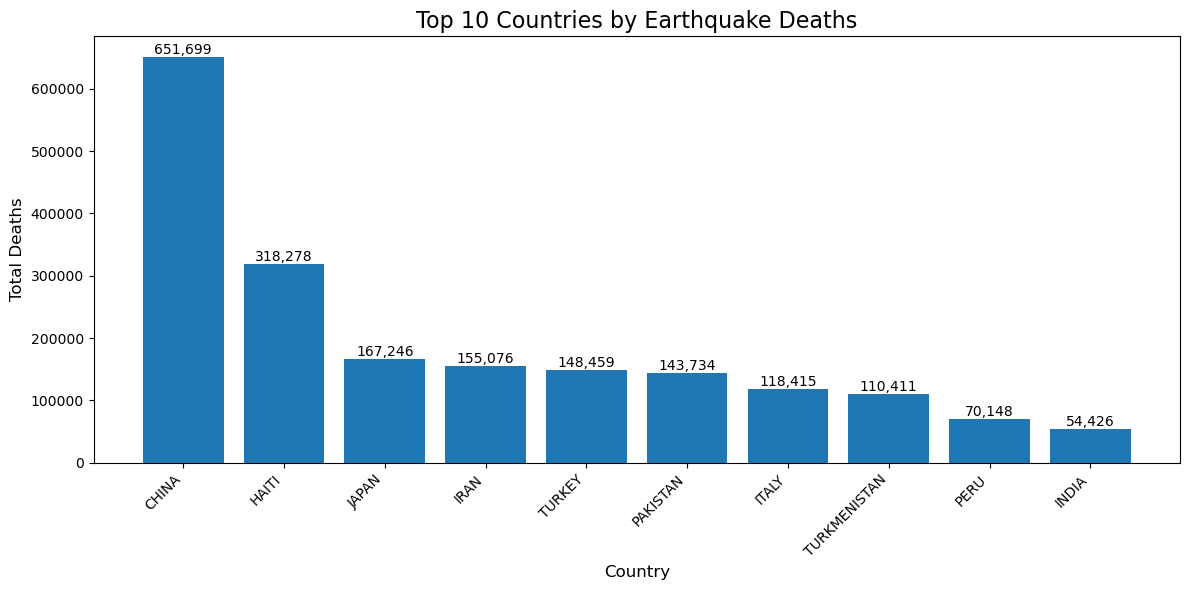

In [ ]:
# Top 10 earthquake deaths per country

# Group the data by country and sum the deaths
eq_deaths = eq.groupby('Country Name')['Deaths'].sum().reset_index()

top_10_countries = eq_deaths.sort_values('Deaths', ascending=False).head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(top_10_countries['Country Name'], top_10_countries['Deaths'])
plt.title('Top 10 Countries by Earthquake Deaths', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of each bar
for i, v in enumerate(top_10_countries['Deaths']):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

plt.show()

In [ ]:
top_10_countries.head(10)

Country Name    Deaths
29          CHINA  651699.0
59          HAITI  318278.0
72          JAPAN  167246.0
67           IRAN  155076.0
141        TURKEY  148459.0
103      PAKISTAN  143734.0
70          ITALY  118415.0
142  TURKMENISTAN  110411.0
106          PERU   70148.0
64          INDIA   54426.0

In [ ]:
# interactive plot 1
eq_gdf = gpd.GeoDataFrame(
    eq, 
    geometry=gpd.points_from_xy(eq['Longitude'], eq['Latitude'])
)

# Create a folium map centered at an average location
center_lat, center_lon = eq_gdf['Latitude'].mean(), eq_gdf['Longitude'].mean()
earthquake_map = folium.Map(
    location=[center_lat, center_lon], 
    zoom_start=2,
    tiles='https://cartodb-basemaps-{s}.global.ssl.fastly.net/light_all/{z}/{x}/{y}{r}.png',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
    name='CartoDB Positron'
)

# Add earthquake points to the map
for _, row in eq_gdf.iterrows():
    popup_info = f"""
    <b>Year:</b> {int(row['Year'])}<br>
    <b>Magnitude:</b> {row['Mag']}<br>
    <b>Deaths:</b> {row['Total Deaths'] if not pd.isna(row['Total Deaths']) else 'N/A'}
    """
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_info, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(earthquake_map)

earthquake_map.save("earthquakes map.html")

In [ ]:
# interactive plot 2
eq_mag = eq.dropna(subset = ['Mag', 'Total Deaths', 'Focal Depth (km)'])

alt.Chart(eq_mag).mark_point().encode(
    alt.X('Mag:Q'),
    alt.Y('Total Deaths:Q'),
    alt.Tooltip(['Focal Depth (km):Q', 'Country Name:N', 'Year:Q'])
).properties(
    title = 'Magnitude vs Total Deaths',
    width = 400, height = 200
)

C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [ ]:
eq_int = eq.dropna(subset = ['Mag', 'Total Deaths', 'Focal Depth (km)', 'Gross domestic product (GDP)'])

selection = alt.selection_interval()

chart = alt.Chart(eq_int).mark_circle().encode(
    alt.X('Mag:Q'),
    alt.Y('Total Deaths:Q'),
    alt.Tooltip(['Country Name:N', 'Year:Q', 'Total Deaths'])
).add_params(
    selection
)

chart | chart.encode(x = 'Gross domestic product (GDP):Q')

C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
C:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.HConcatChart(...)